# Efficient Continuous Pareto Exploration in Multi-Task Learning
Source code for ICML submission #640 "Efficient Continuous Pareto Exploration in Multi-Task Learning"

This script generates Figure 4 in the paper.

# Problem setup

In [1]:
import codecs
import gzip
import os
import sys
import urllib
import pickle

import cvxpy as cp
import numpy as np
import scipy.optimize
from scipy.sparse.linalg import LinearOperator, minres
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torchvision.transforms as transforms
from PIL import Image

from common import *

# Fix the random seed.
np.random.seed(42)
# Use _ to slient manual_seed.
_ = torch.manual_seed(42)

### Downloading MNIST
Here we create 2048 images by overlapping images from MNIST with random perturbations. We start from downloading the original MNIST dataset:

In [2]:
# Download MNIST training images and labels into root_folder.
# Returns (images, labels).
# images is of dimension 60k x h x w, labels is of dimension 60k.
def download_mnist_training(root_folder):
    # Helper function.
    def get_int(b):
        return int(codecs.encode(b, 'hex'), 16)

    # Download data.
    image_url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
    label_url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
    for url in (image_url, label_url):
        data = urllib.request.urlopen(url)
        name = url.rpartition('/')[2]
        file_path = os.path.join(root_folder, name)
        with open(file_path, 'wb') as f:
            f.write(data.read())
        with open(file_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(file_path) as zip_f:
            out_f.write(zip_f.read())
        os.remove(file_path)

    # Extract images.
    with open(os.path.join(root_folder, 'train-images-idx3-ubyte'), 'rb') as f:
        data = f.read()
        # Check the magic number and metadata.
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        assert length == 60000
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        assert num_rows == num_cols == 28
        # Read images.
        image_data = np.frombuffer(data, dtype=np.uint8, offset=16)
        images = image_data.reshape(length, num_rows, num_cols)

    # Extract labels.
    with open(os.path.join(root_folder, 'train-labels-idx1-ubyte'), 'rb') as f:
        data = f.read()
        # Check the magic number and metadata.
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        assert length == 60000
        label_data = np.frombuffer(data, dtype=np.uint8, offset=8)
        labels = label_data.ravel()
    return images, labels

root_folder = 'MultiMNISTSubset'
mnist_images, mnist_labels = download_mnist_training(root_folder)

For a sanity check, we display the labels and images below:

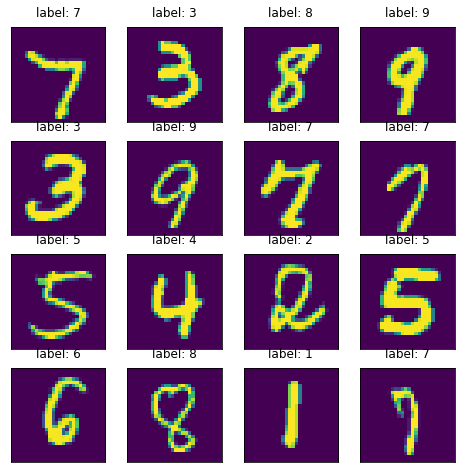

In [3]:
# Visualize MNIST.
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
choice = np.random.choice(mnist_labels.size, 16, replace=False)
for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(4, 4, i * 4 + j + 1)
        ax.matshow(mnist_images[choice[i * 4 + j]])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('label: {}'.format(mnist_labels[choice[i * 4 + j]]))
plt.show()

### Generating MultiMNIST

Now we generate MultiMNIST:

In [4]:
# Returns (images, left_label, right_label).
# images is of size (number, h, w), left_label and right_label are of size (number,)
def generate_multi_mnist(number):
    multi_images = []
    left_labels = []
    right_labels = []
    mnist_size = mnist_labels.size
    left = np.random.permutation(mnist_size)[:number]
    right = np.random.permutation(mnist_size)[:number]
    for l, r in zip(left, right):
        left_labels.append(mnist_labels[l])
        right_labels.append(mnist_labels[r])

        left_image = mnist_images[l]
        right_image = mnist_images[r]
        # Randomly shift left and right images.
        if np.random.rand() < 0.5:
            shift_left = np.random.randint(3)
            shift_right = np.random.randint(4)
        else:
            shift_left = np.random.randint(4)
            shift_right = np.random.randint(3)
        
        new_image = np.zeros((36, 36))
        new_image[shift_left:shift_left + 28, shift_left:shift_left + 28] += left_image
        new_image[8 - shift_right:36 - shift_right, 8 - shift_right:36 - shift_right] += right_image

        # Post-processing.
        new_image = np.clip(new_image, 0, 255).astype(mnist_images[0].dtype)
        # Downsample the image to 14 x 14.
        new_image = np.array(Image.fromarray(new_image).resize((14, 14), resample=Image.NEAREST))
        multi_images.append(new_image)
    return multi_images, left_labels, right_labels

subset_size = 2048
multi_images, left_labels, right_labels = generate_multi_mnist(subset_size)

Again, as a sanity check, we visualize the labels and digits:

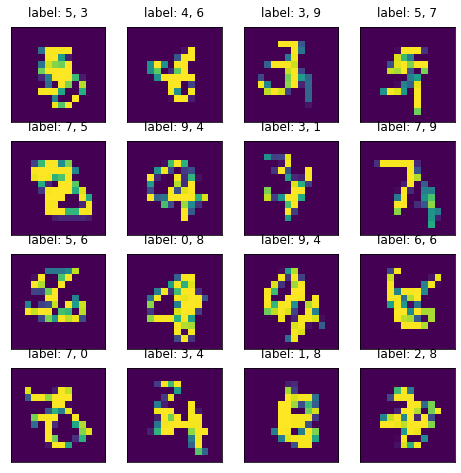

In [5]:
# Visualize MultiMNIST.
fig = plt.figure(figsize=(8, 8))
choice = np.random.choice(subset_size, 16, replace=False)
for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(4, 4, i * 4 + j + 1)
        idx = choice[i * 4 + j]
        ax.matshow(multi_images[idx])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('label: {}, {}'.format(left_labels[idx], right_labels[idx]))
plt.show()

# Our method

### Network and task definition
We start with the definition of our neural network and loss functions. This network has two tails, one for each classification task.

In [6]:
# Define the neural network.
class MiniLeNet(nn.Module):
    def __init__(self):
        super(MiniLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, (5, 5), stride=2)
        self.fc1 = nn.Linear(40, 20)
        self.fc3_1 = nn.Linear(20, 10)
        self.fc3_2 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = [self.fc3_1(x), self.fc3_2(x)]
        return x

network = MiniLeNet()
x0 = ndarray(parameters_to_vector(network.parameters()).clone().detach().numpy())

In [7]:
# Define the loss.
# Transform images to torch tensors and normalize them.
# For MNIST, mean = 0.1307, std = 0.3081
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Dim of multi_images_torch: #images x #channels x height x width.
multi_images_torch = torch.stack([transform(Image.fromarray(img)) for img in multi_images], dim=0)

# Label shape: (#images,)
left_labels_torch = torch.from_numpy(ndarray(left_labels)).long()
right_labels_torch = torch.from_numpy(ndarray(right_labels)).long()

loss_function = nn.CrossEntropyLoss()

def flatten_node(node):
    for i, (node_module, param) in enumerate(zip(node, network.parameters())):
        if node_module is None:
            node[i] = torch.zeros_like(param)
    node_vec = parameters_to_vector(node)
    return node_vec

### Generating the Pareto front

We then generate empirical Pareto front by minimizing the weighted sum of losses with varying weights. Depending on your choice of `num_trials`, this process can take a while. For 101 trials, this cell took around 100 minutes to finish on our computer with PyTorch CPU. We actually used GPU in our experiments but we want to keep this script simple to set up.

We have also attached the training results in this code repository for num_trials = 101. So if you don't plan to use a new `num_trials`, executing this scripyt will load these files directly and will be super fast.

In [8]:
num_trials = 101
for w1 in np.linspace(0, 1, num_trials):
    w2 = 1 - w1

    def loss_and_grad(x):
        x_cp = np.copy(x)
        # Convert x to tensor.
        x_torch = torch.as_tensor(x_cp, dtype=torch.float)

        # Compute loss.
        vector_to_parameters(x_torch, network.parameters())
        logits = network(multi_images_torch)
        loss_left, loss_right = loss_function(logits[0], left_labels_torch), loss_function(logits[1], right_labels_torch)
        loss_torch = w1 * loss_left + w2 * loss_right
        loss = loss_torch.double().clone().detach().cpu().numpy()

        # Compute gradients.
        grad = 0
        for loss_node, w in [(loss_left, w1), (loss_right, w2)]:
            grad_node = list(torch.autograd.grad(loss_node, network.parameters(), retain_graph=True, allow_unused=True))
            grad_vec = flatten_node(grad_node)
            grad += grad_vec.double().clone().detach().numpy() * w
        return loss, grad

    data_file = os.path.join(root_folder, '{:.2f}_{:.2f}.bin'.format(w1, w2))
    if not os.path.exists(data_file):
        result = scipy.optimize.minimize(loss_and_grad, x0, method='L-BFGS-B', jac=True, bounds=None)
        x = result.x
        pickle.dump(x, open(data_file, 'wb'))

The above cell generated 101 solutions but not all of them are Pareto optimal. We now post-process these solutions by filtering out dominated ones and those with extremely bad losses.

In [9]:
# Filter out dominated solutions.

# Helper function.
# Input: numpy array of size 1500.
# Output: two scalars representing the left loss and right loss.
def get_loss(x):
    x_cp = np.copy(x)
    x_torch = torch.as_tensor(x_cp, dtype=torch.float)
    vector_to_parameters(x_torch, network.parameters())
    logits = network(multi_images_torch)
    loss_left, loss_right = loss_function(logits[0], left_labels_torch), loss_function(logits[1], right_labels_torch)
    loss_left = loss_left.double().clone().detach().cpu().numpy()
    loss_right = loss_right.double().clone().detach().cpu().numpy()
    return loss_left, loss_right

pareto = []
for w1 in np.linspace(0, 1, num_trials):
    w2 = 1 - w1
    data_file = os.path.join(root_folder, '{:.2f}_{:.2f}.bin'.format(w1, w2))
    x = pickle.load(open(data_file, 'rb'))
    losses = ndarray(get_loss(x))
    pareto.append((np.copy(x), np.copy(losses), w1, w2))

# Filter out extremely bad solutions.
def in_range(f):
    return 0 <= f[0] <= 2.0 and 0.5 <= f[1] <= 2.5

pareto_filtered = []
for x, losses, w1, w2 in pareto:
    # Filter out dominated solutions.
    if np.any([np.min(losses - losses2) > 0 for _, losses2, _, _ in pareto]) or not in_range(losses): continue
    pareto_filtered.append((np.copy(x), np.copy(losses), w1, w2))

# Sort pareto_filtered.
pareto_filtered = sorted(pareto_filtered, key=lambda x: x[1][0])

Now let's plot the empirical Pareto front:

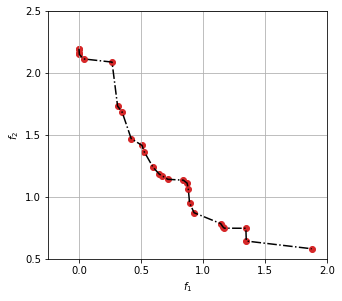

In [10]:
# Plot the empirical Pareto front.
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
pareto_front = ndarray([np.copy(l) for _, l, _, _ in pareto_filtered])
pareto_front = ndarray(pareto_front)
ax.plot(pareto_front[:, 0], pareto_front[:, 1], 'k-.')
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], c='tab:red')
ax.set_aspect('equal')
ax.set_xlabel('$f_1$')
ax.set_ylabel('$f_2$')
ax.set_xticks(np.linspace(0, 2.0, 5))
ax.set_yticks(np.linspace(0.5, 2.5, 5))
ax.set_xlim([-0.25, 2.0])
ax.set_ylim([0.5, 2.5])
ax.grid(True)
plt.show()

Finally, we define our method and the weighted sum baseline for Pareto expansion.

In [11]:
# Compare two expansion strategies.

# A helper function for gradient correction.
def correct_gradients(g, alpha):
    g_corrected = ndarray([gi - alpha.T @ g for gi in g])
    # We can still use the same alpha.
    return g_corrected

# Given network parameters x (a numpy array), return a 2 x n gradient numpy array.
def get_grad(x):
    x_cp = np.copy(x)
    # Convert x to tensor.
    x_torch = torch.as_tensor(x_cp, dtype=torch.float)
    vector_to_parameters(x_torch, network.parameters())
    logits = network(multi_images_torch)
    loss_left, loss_right = loss_function(logits[0], left_labels_torch), loss_function(logits[1], right_labels_torch)

    # Compute gradients.
    grad_np = []
    for loss_node in (loss_left, loss_right):
        grad_node = list(torch.autograd.grad(loss_node, network.parameters(), retain_graph=True, allow_unused=True))
        grad_vec = flatten_node(grad_node)
        grad_np.append(grad_vec.double().clone().detach().numpy())
    return ndarray(grad_np)

# The WeightedSum baseline at one single Pareto optimal solution: given a weight vector, run GD for num_iter iterations
# to minimize w[0] * f[0] + w[1] * f[1]
# Input:
# - x_init: a 1500-dimensional numpy array representing the neural network parameter;
# - num_iter: the maximum allowable number of gradient-descend iterations;
# - w: the weight vector (2 dimensional).
# Output:
# - A list of intermediate solutions (x[i], f[i]) explored by GD at each iteration.
def expand_ws(x_init, num_iter, w):
    # Hyperparameters for WeightedSum.
    lr_init = 5e-2
    history = [(np.copy(x_init), ndarray(get_loss(x_init)))]
    for t in range(num_iter):
        lr = lr_init / np.sqrt(t + 1)
        # Compute the gradient.
        xi = np.copy(history[-1][0])
        g = ndarray(w).T @ get_grad(xi)
        xi -= lr * g
        history.append((xi, ndarray(get_loss(xi))))
    return history

# Similar to expand_ws except that bfgs is used instead of gd.
def expand_bfgs(x_init, num_iter, w):
    history = []
    def loss_and_grad(x):
        loss = get_loss(x)
        grad = get_grad(x)
        loss, grad = ndarray(w).dot(ndarray(loss)), ndarray(w).T @ grad
        history.append((np.copy(x), ndarray(get_loss(x))))
        return loss, grad

    result = scipy.optimize.minimize(loss_and_grad, x_init, method='L-BFGS-B', jac=True, bounds=None, options={ 'maxiter': num_iter })
    x = result.x
    return history

# The MINRES method at one single Pareto optimal solution: run MINRES for num_iter iterations then move x0 along the
# approximated tangent.
# Input:
# - x_init: a 1500-dimensional numpy array representing the neural network parameter;
# - num_iter: the maximum allowable number of MINRES iterations;
# Output:
# - A 1500-dimensional tangent direction.
def expand_minres(x_init, num_iter):
    # Solve alpha in MGDA: note that this does not increment the counter and g[0] and g[1] are not necessarily parallel.
    def compute_alpha(g):
        g = ndarray(g)
        alpha = cp.Variable(2)
        objective = cp.Minimize(cp.sum_squares(alpha.T @ g))
        constraints = [alpha >= 0, cp.sum(alpha) == 1]
        alpha_prob = cp.Problem(objective, constraints)
        optimal_loss = alpha_prob.solve()
        alpha = ndarray(alpha.value).ravel()
        return alpha
    grad = get_grad(x_init)
    alpha = compute_alpha(grad)
    grad = correct_gradients(grad, alpha)
    assert np.allclose(alpha.T @ grad, 0)
    n = grad.shape[1]

    # Matrix-free iterative solver.
    x_torch = torch.as_tensor(x_init, dtype=torch.float)
    vector_to_parameters(x_torch, network.parameters())
    logits = network(multi_images_torch)
    loss_left, loss_right = loss_function(logits[0], left_labels_torch), loss_function(logits[1], right_labels_torch)
    # Compute the grad node.
    grad_left = list(torch.autograd.grad(loss_left, network.parameters(), retain_graph=True, allow_unused=True, create_graph=True))
    grad_right = list(torch.autograd.grad(loss_right, network.parameters(), retain_graph=True, allow_unused=True, create_graph=True))
    grad_left_vec = flatten_node(grad_left)
    grad_right_vec = flatten_node(grad_right)
    weighted_sum_grad = alpha[0] * grad_left_vec + alpha[1] * grad_right_vec
    def H_op(y):
        y = ndarray(y).ravel()
        assert y.size == n
        dot_prod = weighted_sum_grad.mul(torch.as_tensor(y, dtype=torch.float)).sum()
        hvp = list(torch.autograd.grad(dot_prod, network.parameters(), retain_graph=True, allow_unused=True))
        hvp = flatten_node(hvp)
        return ndarray(hvp.clone().detach().numpy())

    # Randomly pick a vector from the column space of grad.T
    rhs = np.random.normal(size=2).T @ grad
    rhs /= np.linalg.norm(rhs)
    result = minres(LinearOperator((n, n), matvec=H_op, rmatvec=H_op), rhs, maxiter=num_iter)
    v = result[0]
    return v / np.linalg.norm(v)

def expand_random(x_init, num_iter):
    return np.random.normal(size=1500)

# Visualization

We now conduct the experiments and visualize the results. Note that similar to what has happened in ZDT2-variant, weighted sum (blue and green) quickly generates directions that lead to the dominated interior while moving along the approximated tangent directions tracks the emprical Pareto front better.

This experiment takes a few minutes to finish.

GD-f_1 progress: 100.00% done...
GD-f_2 progress: 100.00% done...
MINRES progress: 100.00% done...


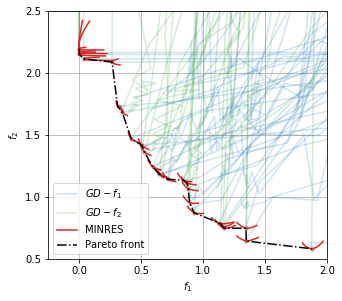

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot the WeightedSum baseline -- you can try adding new weights or replace expand_ws with expand_bfgs too.
# Each iter at expand_ws consumes 1 call to eval f and 1 call to eval grad.
num_iter = 50

for w, color, label in [([1, 0], 'tab:blue', '$GD-f_1$'), ([0, 1], 'tab:green', '$GD-f_2$')]:
    for i, (xi, _, _, _) in enumerate(pareto_filtered):
        sys.stdout.write('\r{} progress: {:5.2f}% done...'.format(label.replace('$', ''), (i + 1) / len(pareto_filtered) * 100))
        sys.stdout.flush()
        xi = pareto_filtered[i][0]
        history = expand_ws(xi, num_iter, w)
        traj = ndarray([fi for _, fi in history])
        ax.plot(traj[:, 0], traj[:, 1], c=color, alpha=0.2, label=label if i == 0 else None)
    sys.stdout.write('\n')

# Plot the MINRES results -- you can replace expand_minres with expand_random if you want to know if tangent directions
# are truly effective.
# Each iter at expand_minres consumes 1 call to eval hvp.
for i, (xi, _, _, _) in enumerate(pareto_filtered):
    sys.stdout.write('\rMINRES progress: {:5.2f}% done...'.format((i + 1) / len(pareto_filtered) * 100))
    sys.stdout.flush()
    v = expand_minres(xi, num_iter)
    v /= np.linalg.norm(v)
    traj = ndarray([get_loss(xi + s * v) for s in np.linspace(-0.5, 0.5, 201)])
    ax.plot(traj[:, 0], traj[:, 1], c='tab:red', label='MINRES' if i == 0 else None)
sys.stdout.write('\n')

# Plot the Pareto front.
ax.plot(pareto_front[:, 0], pareto_front[:, 1], 'k-.', label='Pareto front')
ax.scatter(pareto_front[:, 0], pareto_front[:, 1], c='tab:red', s=10, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('$f_1$')
ax.set_ylabel('$f_2$')
ax.set_xticks(np.linspace(0, 2.0, 5))
ax.set_yticks(np.linspace(0.5, 2.5, 5))
ax.set_xlim([-0.25, 2.0])
ax.set_ylim([0.5, 2.5])
ax.legend()
ax.grid(True)
plt.show()